In [27]:
%pylab
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [28]:
def encode_manchester(bits):
    manchester = np.array([[False, True] if b else [True, False] for b in bits])
    manchester = np.reshape(manchester, (-1, 1))
    return manchester

In [29]:
def generate_am_signal(manchester_encoding, frequency, samp_per_bit, num_samples, samp_rate):
    M = np.tile(manchester_encoding,(1,int(samp_per_bit)))
    t = r_[0.0:2*num_samples]/samp_rate
    am_signal = M.ravel()*np.sin(2*np.pi*frequency*t)
    return am_signal, t

In [30]:
def transmit(data, samp_rate, baud, frequency, len_preamble, packet_id='11111111', length=44):
    preamble = ''.join('1' for _ in range(8))
    len_packet = '00' + str(bin(length))[2:]
    components = [preamble, packet_id, len_packet, data]
    grid = []
    for component in components:
        grid.append([int(d) for d in component])
    grid = np.array(grid)
    print(grid)
    
    col_parity = grid.sum(axis=0) % 2
    row_parity = grid.sum(axis=1) % 2
    
    packet = [d == 1 for d in np.nditer(grid)]
    packet += [d == 1 for d in col_parity]
    packet += [d == 1 for d in row_parity]
    packet = np.array(packet).reshape(-1,1)
    
    samp_per_bit = samp_rate/baud
    num_samples = length * samp_per_bit
    manchester = encode_manchester(packet)
    am_signal, t = generate_am_signal(manchester, frequency, samp_per_bit, num_samples, samp_rate)
    sd.play(am_signal, blocking=True)
    return packet, am_signal, t

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [0 0 1 0 1 1 0 0]
 [1 1 0 0 1 0 1 1]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]


Text(0.5,0,'time [s]')

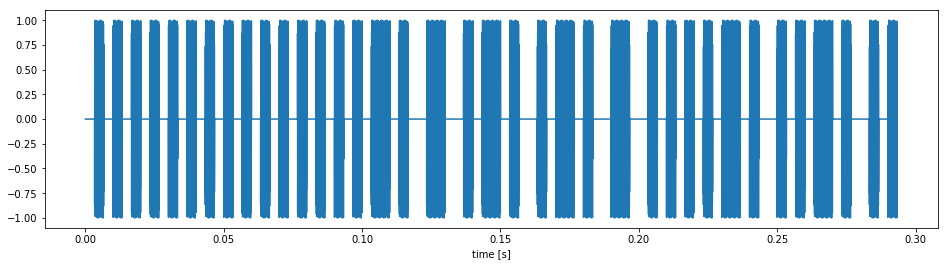

In [31]:
samp_rate = 44100  # sampling rate
baud = 300  # symbol rate
len_preamble = 10
frequency = int(88.1e6)
data ='11001011'

bits, am_signal, t = transmit(data, samp_rate, baud, frequency, len_preamble)
output = []
for b in bits:
    if b:
        output.append(1)
    else:
        output.append(0)
print(output)
fig = figure(figsize = (16,4))
plot(t, am_signal)
xlabel('time [s]')